In [1]:
#rcParams['savefig.dpi'] = 75

#from mpl_toolkits.basemap import Basemap
%matplotlib inline
from matplotlib.pylab import *
import numpy as np

from sigvisa import Sigvisa
from sigvisa.source.event import get_event, Event
from sigvisa.signals.io import fetch_waveform, EventNotDetected, MissingWaveform
from sigvisa.signals.common import Waveform

from sigvisa.models.ttime import tt_predict

from sigvisa.graph.sigvisa_graph import SigvisaGraph
from sigvisa.infer.optimize.optim_utils import construct_optim_params
from sigvisa.plotting.plot import plot_det_times, plot_pred_atimes
from sigvisa.database.dataset import read_evids_detected_at_station, read_event_detections, DET_TIME_COL

from sigvisa.graph.load_sigvisa_graph import load_sg_from_db_fit
from sigvisa.models.wiggles.wavelets import construct_full_basis_implicit

/home/dmoore/python/sigvisa/treegp/gpy_linalg.py:39: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


In [2]:
from sigvisa.models.distributions import TruncatedGaussian, Gaussian, MultiGaussian, InvGamma

import seaborn as sns
blue, green, red, purple = sns.color_palette()[:4]


In [3]:
sg = SigvisaGraph(wiggle_family='db4_2.0_3_20.0', 
                  template_shape="lin_polyexp",
                  phases=['Pg',], 
                  wiggle_model_type="dummy",
                  template_model_type="param",
                  min_mb=1.0,
                  raw_signals=True,
                  dummy_fallback=True,
                  runids=(31,))


srate=10.0
w = Waveform(np.zeros((int(srate*60),)), srate=srate, stime=1243212800.0, sta="ELK", chan="BHZ")
wf = w.filter("freq_0.8_4.5")
wn = sg.add_wave(wf, fixed=False)

wn.nm_node.prior_mean_dist = Gaussian(0.0, std=1e-4)
prior_alpha = 100.0
baseline_std = 10.0
wn.nm_node.prior_var_dist = InvGamma(prior_alpha, baseline_std**2 * (prior_alpha - 1))

n_p = len(wn.nm_node.prior_nm.params)
prior_params = np.zeros((n_p,))
prior_params[0] = 0.4
wn.nm_node.prior_param_dist = MultiGaussian(prior_params, np.eye(n_p) * 0.01, pre_inv=True)


ev = Event(lon=-114.0, lat=41.0, mb=1.7, depth=0.0, time=wn.st - 15 )
sg.add_event(ev, fixed=True)




warning, no hparam prior specified for mult_wiggle_std , using dummy
tuple index out of range
sta: ELK, chan BHZ. filter_str: ;freq_0.8_4.5, fraction_valid: 1, npts: 600, srate: 10.0, valid_len: 60.0


{'depth': <NODE 1;loc>,
 'lat': <NODE 1;loc>,
 'loc': <NODE 1;loc>,
 'lon': <NODE 1;loc>,
 'mb': <NODE 1;mb>,
 'natural_source': <NODE 1;source>,
 'time': <NODE 1;time>}

In [4]:
seed=28 #15
np.random.seed(seed)
sg.parent_sample_all()

sampling w/ seed 1465090948


/home/dmoore/python/sigvisa/models/signal_model.py:662: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return TransientCombinedSSM(components, TSSM_NOISE_PADDING)


In [5]:
print wn.arrivals()
print wn.get_template_params_for_arrival(1, "Pg")

nodes = sg.get_template_nodes(1, wn.sta, "Pg", wn.band, wn.chan)

nodes["coda_height"][1].set_value(4.2)
nodes["coda_decay"][1].set_value(-2.0)
nodes["peak_decay"][1].set_value(-1.4)
nodes["peak_offset"][1].set_value(0.0)
nodes["arrival_time"][1].set_value(1243212805)

np.random.seed(seed)
wn.parent_sample()

set([(1, 'Pg')])
({'coda_height': -1.7921249369436634, 'arrival_time': 1243212803.7152417, 'coda_decay': -5.937124730318579, 'peak_decay': -16.34860549031454, 'peak_offset': 15.367602340658875}, <sigvisa.models.templates.lin_polyexp.LinPolyExpTemplateGenerator object at 0x7ff601bad550>)
sampling w/ seed 983606529


reading station detections... 


/home/dmoore/.virtualenvs/sigvisa/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


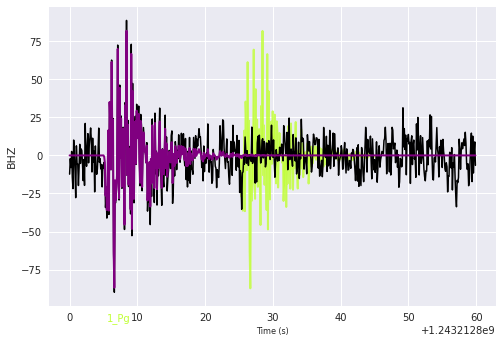

In [6]:
wn.plot(ax=gca())

(1243212804.0, 1243212820.0)

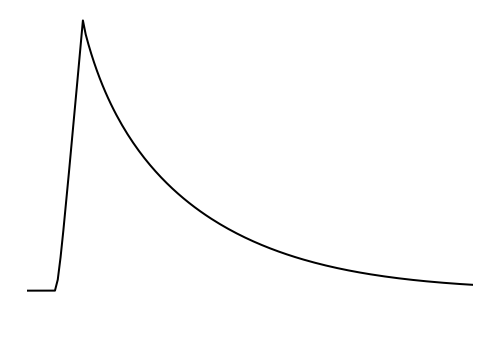

In [7]:
def plot_bare(data, x, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
    ax.axis('off')
    ax.plot(x, data, **kwargs)
    return ax


#d = wn.get_value()
wn.tssm = wn.transient_ssm()
#lp1, marginals, step_ells = wn.tssm.all_filtered_cssm_coef_marginals(d)
#posterior_means, posterior_vars = marginals[2]
cssm = wn.arrival_ssms[(1, "Pg")]
ncoefs = len(wn.wavelet_param_models["Pg"])
prior_means, prior_vars = np.zeros((ncoefs,)), np.ones((ncoefs,))
cssm.set_coef_prior(prior_means, prior_vars)

template = wn.tssm.obs_var(wn.npts)
template = np.sqrt(template)
x = np.linspace(wn.st, wn.et, wn.npts)

ax = plot_bare(template, x, color="black", linewidth=2)
ax.set_xlim([wn.st+4, wn.st+20])

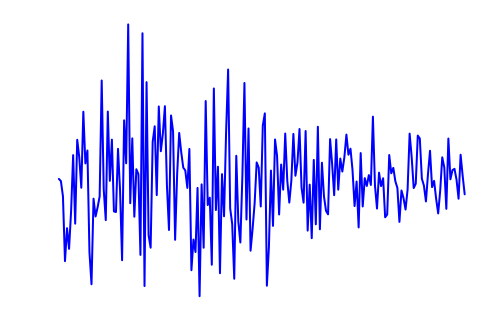

In [8]:

d = wn.get_value()
lp1, marginals, step_ells = wn.tssm.all_filtered_cssm_coef_marginals(d)
posterior_means1, posterior_vars1 = marginals[1]
cssm = wn.arrival_ssms[(1, "Pg")]
cssm.set_coef_prior(posterior_means1, posterior_vars1)


wiggle = cssm.mean_obs(200)
ax = plot_bare(wiggle, np.linspace(0, 20, 200), color="blue", linewidth=2)



In [9]:
noise_var = template[23]**2
noiseless_template = np.sqrt(template**2 - noise_var)

/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


(1243212804.0, 1243212820.0)

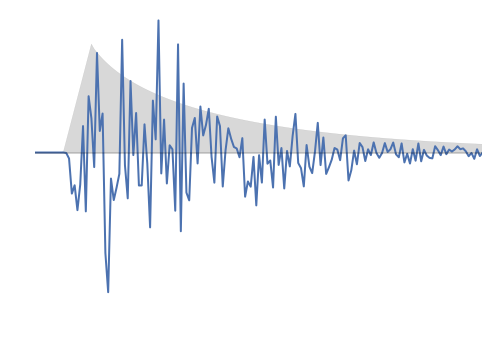

In [10]:
pred_signal = wn.tssm.mean_obs(wn.npts)
noise = wn.nm.sample(len(pred_signal))
ss = pred_signal+noise

ax = plot_bare(pred_signal, x, color=blue, linewidth=2, alpha=1.0)
ax.plot(x, np.zeros(x.shape), color="black", alpha=0.2)
ax.fill_between(x,  0, noiseless_template, color="gray", alpha=0.3)
ax.set_xlim([wn.st+4, wn.st+20])



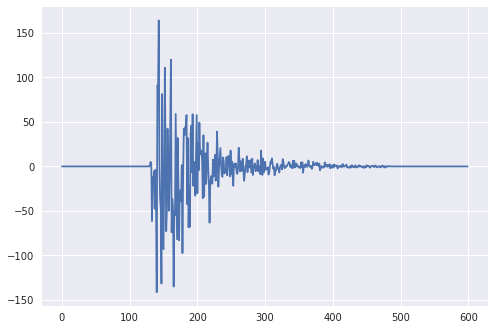

In [11]:
atime = nodes["arrival_time"][1].get_value()
sidx = int((atime - wn.st) * wn.srate)

ps1 = noiseless_template.copy()
np.random.seed(3)
ps1[sidx:] *= np.random.randn(len(ps1)-sidx)

ps1_shifted = np.zeros(noiseless_template.shape)
nt_shifted = np.zeros(noiseless_template.shape)
sidx2 = int( sidx + 3*wn.srate)
ps1_shifted[sidx2:] = 1.6*ps1[:len(ps1)-sidx2]
nt_shifted[sidx2:] = 1.6*noiseless_template[:len(ps1)-sidx2]

ps1_shifted[np.isnan(ps1_shifted)] = 0.0

plt.plot(ps1_shifted)

(1243212802.0, 1243212835.0)

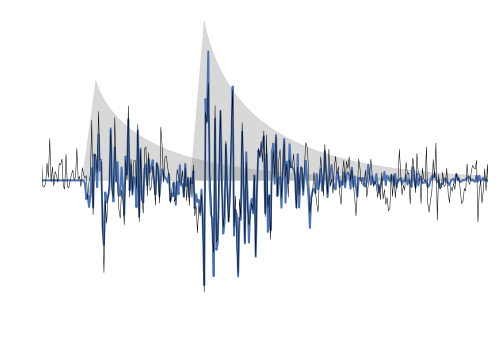

In [12]:
ss2 = pred_signal + noise*2 + ps1_shifted

ax = plot_bare(pred_signal+ps1_shifted, x, color=blue, linewidth=2, ls="-", alpha=1.0)
#ax.plot(x, pred_signal+ps1_shifted, color=green, linewidth=2, ls="-", alpha=1.0)

ax.plot(x, ss2, color="black", linewidth=0.5)
ax.fill_between(x,  0, noiseless_template*2, color="gray", alpha=0.3)
ax.fill_between(x,  0, nt_shifted*2, color="gray", alpha=0.3)

ax.set_xlim([wn.st+2, wn.st+35])


/home/dmoore/.virtualenvs/sigvisa/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in sqrt


(1243212802.0, 1243212825.0)

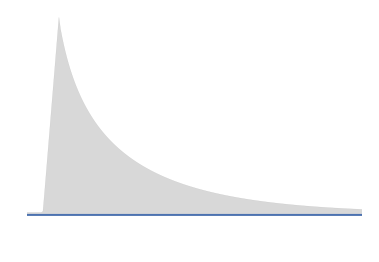

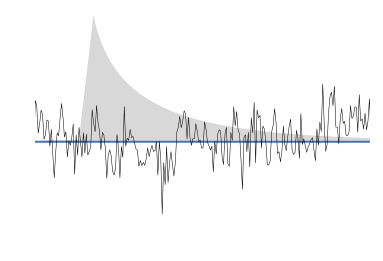

In [80]:
d = wn.get_value()
wn.tssm = wn.transient_ssm()

lp1, marginals, step_ells = wn.tssm.all_filtered_cssm_coef_marginals(d)
posterior_means, posterior_vars = marginals[1]
cssm = wn.arrival_ssms[(1, "Pg")]
cssm.set_coef_prior(posterior_means, posterior_vars)


pred_signal = wn.tssm.mean_obs(wn.npts)
noise = wn.nm.sample(len(pred_signal))
ss = pred_signal+noise

noise_var = template[23]**2
noiseless_template = np.sqrt(template**2 - noise_var)

ax = plot_bare(pred_signal, x, color=blue, linewidth=2, alpha=1.0)
ax.fill_between(x,  0, noiseless_template, color="gray", alpha=0.3)

ax.set_xlim([wn.st+4, wn.st+25])

ax = plot_bare(pred_signal, x, color=blue, linewidth=2, ls="-", alpha=1.0)
ax.plot(x, ss, color="black", linewidth=0.5)
ax.fill_between(x,  0, noiseless_template, color="gray", alpha=0.3)

ax.set_xlim([wn.st+2, wn.st+25])

